In [41]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
# Import your dataset and transforms
from dataset_creater import *
from torchsummary import summary


In [42]:
# Set the path to your dataset
data_folder = "./data"
transform = Spectrogram_transform

# Create an instance of your dataset
dataset = AudioDataset(data_folder, transform=transform, scale=(-80, 0))

# Define the sizes of your splits
train_size = int(0.8 * len(dataset))
val_size = int(0.10 * len(dataset))
test_size = len(dataset) - train_size - val_size

# Use random_split to create training, validation, and test sets
train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size])

batch_size = 32
# Move the training and validation data loaders to the selected device
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, shuffle=False)
test_loader = DataLoader(test_set, shuffle=False)

# Calculate the fc1 input size
for batch in train_loader:
    sample, label =  batch
    if len(sample.size()) == 3:
        fc1_input_size = sample.size(len(sample.size())-1)
        print(fc1_input_size)
    elif len(sample.size()) == 4:
        fc1_input_size = sample.size(len(sample.size())-1) * sample.size(len(sample.size())-2)
        print(fc1_input_size)
    break

25472


In [43]:
min_amplitude = np.inf
max_amplitude = -np.inf
for batch in train_loader:
    padded_waveforms, labels = batch
    # print("Padded waveforms shape:", padded_waveforms.shape)
    input_shape = padded_waveforms.shape[1:]
    if min_amplitude > padded_waveforms.min():
        min_amplitude = padded_waveforms.min()
    if max_amplitude < padded_waveforms.max():
        max_amplitude = padded_waveforms.max()
    input_shape = padded_waveforms.shape[1:]
print(input_shape)
print("Min amplitude:", min_amplitude)
print("Max amplitude:", max_amplitude)

torch.Size([1, 128, 199])
Min amplitude: tensor(0.)
Max amplitude: tensor(1.)


In [44]:
class ChordClassifier(nn.Module):
    def __init__(self):
        super(ChordClassifier, self).__init__()
        # Define a CNN with input shape is (batch_size, 1, 128, 199) and output shape is (batch_size, 1)
        # it should reduce the dimensionality very quickly because the dataset is small (<1000)
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=0) 
        self.bn1 = nn.BatchNorm2d(16)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) 
        self.conv2 = nn.Conv2d(16, 64, kernel_size=5, stride=1, padding=0) 
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=4, stride=4) 
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=0)
        self.relu3 = nn.ReLU()
        # global average pooling
        self.pool3 = nn.AdaptiveAvgPool2d((2, 2)) # shape (batch_size, 128, 1, 1)
        self.bn3 = nn.BatchNorm1d(64 * 2 * 2)
        self.dropout1 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(64 * 2 * 2, 32)
        self.relu4 = nn.ReLU()
        self.bn4 = nn.BatchNorm1d(32)
        self.dropout2 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(32, 1)
         # no activation function because we use BCEWithLogitsLoss

    def forward(self, x):
        x = self.pool1(self.relu1(self.bn1(self.conv1(x))))
        x = self.pool2(self.relu2(self.bn2(self.conv2(x))))
        x = self.pool3(self.relu3(self.conv3(x)))
        x = x.view(x.size(0), -1) # flatten the tensor before fully connected layer
        x = self.bn3(x)
        x = self.dropout1(x)
        x = self.fc1(x)
        x = self.relu4(x)
        x = self.bn4(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        # Use BCEWithLogitsLoss instead of BCELoss because it combines a Sigmoid layer and the BCELoss in one single class
        # the output shape should be (batch_size,)
        return x.view(-1)


'''


import torch.nn as nn

class ChordClassifier(nn.Module):
    def __init__(self):
        super(ChordClassifier, self).__init__()

        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        
        # Add more hidden layers
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.relu4 = nn.ReLU()
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        

        # Adjust the size of the fully connected layer
        self.fc1 = nn.Linear(24576, 512)  # Adapt this size based on your actual tensor size
        self.relu5 = nn.ReLU()
        self.fc2 = nn.Linear(512, 128)
        self.relu6 = nn.ReLU()
        self.fc3 = nn.Linear(128, 2)  # 2 classes: Major and Minor

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.pool3(self.relu3(self.conv3(x)))
        x = self.pool4(self.relu4(self.conv4(x)))

        x = x.view(x.size(0), -1)  # Flatten the tensor before fully connected layer

        x = self.relu5(self.fc1(x))
        x = self.relu6(self.fc2(x))
        x = self.fc3(x)

        return x
'''

'\n\n\nimport torch.nn as nn\n\nclass ChordClassifier(nn.Module):\n    def __init__(self):\n        super(ChordClassifier, self).__init__()\n\n        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)\n        self.relu1 = nn.ReLU()\n        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)\n\n        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)\n        self.relu2 = nn.ReLU()\n        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)\n\n        \n        # Add more hidden layers\n        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)\n        self.relu3 = nn.ReLU()\n        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)\n\n        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)\n        self.relu4 = nn.ReLU()\n        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)\n        \n\n        # Adjust the size of the fully connected layer\n        self.fc1 = nn.Linear(24576, 512)  # Adapt this size based

In [45]:


# Check if GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate model and move it to the selected device
model = ChordClassifier().to(device)

# Instantiate loss function and move it to the selected device
criterion = nn.BCEWithLogitsLoss().to(device)

# Instantiate optimizer and move it to the selected device
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.1)

# output summary of model
summary(model, input_size=input_shape)



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 124, 195]             416
       BatchNorm2d-2         [-1, 16, 124, 195]              32
              ReLU-3         [-1, 16, 124, 195]               0
         MaxPool2d-4           [-1, 16, 62, 97]               0
            Conv2d-5           [-1, 64, 58, 93]          25,664
       BatchNorm2d-6           [-1, 64, 58, 93]             128
              ReLU-7           [-1, 64, 58, 93]               0
         MaxPool2d-8           [-1, 64, 14, 23]               0
            Conv2d-9           [-1, 64, 12, 21]          36,928
             ReLU-10           [-1, 64, 12, 21]               0
AdaptiveAvgPool2d-11             [-1, 64, 2, 2]               0
      BatchNorm1d-12                  [-1, 256]             512
          Dropout-13                  [-1, 256]               0
           Linear-14                   

100%|██████████| 22/22 [00:08<00:00,  2.69it/s]


Training - Epoch 1/70, Loss: 0.7523, Accuracy: 0.5386
Validation - Epoch 1/70, Loss: 0.6955, Accuracy: 0.5882


100%|██████████| 22/22 [00:07<00:00,  2.79it/s]


Training - Epoch 2/70, Loss: 0.7147, Accuracy: 0.5881
Validation - Epoch 2/70, Loss: 0.7718, Accuracy: 0.4824


100%|██████████| 22/22 [00:08<00:00,  2.73it/s]


Training - Epoch 3/70, Loss: 0.6936, Accuracy: 0.5939
Validation - Epoch 3/70, Loss: 0.7321, Accuracy: 0.5882


100%|██████████| 22/22 [00:08<00:00,  2.59it/s]


Training - Epoch 4/70, Loss: 0.6710, Accuracy: 0.6230
Validation - Epoch 4/70, Loss: 0.6815, Accuracy: 0.6118


100%|██████████| 22/22 [00:08<00:00,  2.66it/s]


Training - Epoch 5/70, Loss: 0.6648, Accuracy: 0.6128
Validation - Epoch 5/70, Loss: 0.6633, Accuracy: 0.5882


100%|██████████| 22/22 [00:08<00:00,  2.65it/s]


Training - Epoch 6/70, Loss: 0.6690, Accuracy: 0.6332
Validation - Epoch 6/70, Loss: 0.6631, Accuracy: 0.6000


100%|██████████| 22/22 [00:08<00:00,  2.70it/s]


Training - Epoch 7/70, Loss: 0.6563, Accuracy: 0.6317
Validation - Epoch 7/70, Loss: 0.6915, Accuracy: 0.6118


100%|██████████| 22/22 [00:08<00:00,  2.59it/s]


Training - Epoch 8/70, Loss: 0.6549, Accuracy: 0.6332
Validation - Epoch 8/70, Loss: 0.6945, Accuracy: 0.6000


100%|██████████| 22/22 [00:08<00:00,  2.60it/s]


Training - Epoch 9/70, Loss: 0.6464, Accuracy: 0.6550
Validation - Epoch 9/70, Loss: 0.6554, Accuracy: 0.6118


100%|██████████| 22/22 [00:08<00:00,  2.59it/s]


Training - Epoch 10/70, Loss: 0.6475, Accuracy: 0.6550
Validation - Epoch 10/70, Loss: 0.6487, Accuracy: 0.6235


100%|██████████| 22/22 [00:08<00:00,  2.64it/s]


Training - Epoch 11/70, Loss: 0.6216, Accuracy: 0.6769
Validation - Epoch 11/70, Loss: 0.6404, Accuracy: 0.6118


100%|██████████| 22/22 [00:08<00:00,  2.56it/s]


Training - Epoch 12/70, Loss: 0.5967, Accuracy: 0.7060
Validation - Epoch 12/70, Loss: 0.6558, Accuracy: 0.5765


100%|██████████| 22/22 [00:08<00:00,  2.68it/s]


Training - Epoch 13/70, Loss: 0.6153, Accuracy: 0.6754
Validation - Epoch 13/70, Loss: 0.6909, Accuracy: 0.6353


100%|██████████| 22/22 [00:08<00:00,  2.61it/s]


Training - Epoch 14/70, Loss: 0.5970, Accuracy: 0.6972
Validation - Epoch 14/70, Loss: 0.6317, Accuracy: 0.6588


100%|██████████| 22/22 [00:08<00:00,  2.58it/s]


Training - Epoch 15/70, Loss: 0.5980, Accuracy: 0.6841
Validation - Epoch 15/70, Loss: 0.6258, Accuracy: 0.6353


100%|██████████| 22/22 [00:08<00:00,  2.66it/s]


Training - Epoch 16/70, Loss: 0.5918, Accuracy: 0.7045
Validation - Epoch 16/70, Loss: 0.6193, Accuracy: 0.5882


100%|██████████| 22/22 [00:08<00:00,  2.58it/s]


Training - Epoch 17/70, Loss: 0.5788, Accuracy: 0.7176
Validation - Epoch 17/70, Loss: 0.6993, Accuracy: 0.6353


100%|██████████| 22/22 [00:08<00:00,  2.68it/s]


Training - Epoch 18/70, Loss: 0.5681, Accuracy: 0.7162
Validation - Epoch 18/70, Loss: 0.6121, Accuracy: 0.6471


100%|██████████| 22/22 [00:08<00:00,  2.67it/s]


Training - Epoch 19/70, Loss: 0.5750, Accuracy: 0.7045
Validation - Epoch 19/70, Loss: 0.6202, Accuracy: 0.6471


100%|██████████| 22/22 [00:08<00:00,  2.66it/s]


Training - Epoch 20/70, Loss: 0.5543, Accuracy: 0.7234
Validation - Epoch 20/70, Loss: 0.5945, Accuracy: 0.6588


100%|██████████| 22/22 [00:08<00:00,  2.64it/s]


Training - Epoch 21/70, Loss: 0.5340, Accuracy: 0.7496
Validation - Epoch 21/70, Loss: 0.6057, Accuracy: 0.6353


100%|██████████| 22/22 [00:08<00:00,  2.63it/s]


Training - Epoch 22/70, Loss: 0.5172, Accuracy: 0.7642
Validation - Epoch 22/70, Loss: 0.7284, Accuracy: 0.6235


100%|██████████| 22/22 [00:08<00:00,  2.68it/s]


Training - Epoch 23/70, Loss: 0.5040, Accuracy: 0.7700
Validation - Epoch 23/70, Loss: 0.6763, Accuracy: 0.5882


100%|██████████| 22/22 [00:08<00:00,  2.64it/s]


Training - Epoch 24/70, Loss: 0.5102, Accuracy: 0.7598
Validation - Epoch 24/70, Loss: 0.6080, Accuracy: 0.6706


100%|██████████| 22/22 [00:08<00:00,  2.66it/s]


Training - Epoch 25/70, Loss: 0.5066, Accuracy: 0.7642
Validation - Epoch 25/70, Loss: 0.6471, Accuracy: 0.7059


100%|██████████| 22/22 [00:08<00:00,  2.64it/s]


Training - Epoch 26/70, Loss: 0.4913, Accuracy: 0.7758
Validation - Epoch 26/70, Loss: 0.5888, Accuracy: 0.6706


100%|██████████| 22/22 [00:08<00:00,  2.62it/s]


Training - Epoch 27/70, Loss: 0.4656, Accuracy: 0.8035
Validation - Epoch 27/70, Loss: 0.5918, Accuracy: 0.6588


100%|██████████| 22/22 [00:08<00:00,  2.62it/s]


Training - Epoch 28/70, Loss: 0.4727, Accuracy: 0.7904
Validation - Epoch 28/70, Loss: 0.7328, Accuracy: 0.5882


100%|██████████| 22/22 [00:08<00:00,  2.61it/s]


Training - Epoch 29/70, Loss: 0.4834, Accuracy: 0.7802
Validation - Epoch 29/70, Loss: 0.6000, Accuracy: 0.6353


100%|██████████| 22/22 [00:08<00:00,  2.64it/s]


Training - Epoch 30/70, Loss: 0.4600, Accuracy: 0.8006
Validation - Epoch 30/70, Loss: 0.7089, Accuracy: 0.6588


100%|██████████| 22/22 [00:08<00:00,  2.61it/s]


Training - Epoch 31/70, Loss: 0.4521, Accuracy: 0.7962
Validation - Epoch 31/70, Loss: 0.5667, Accuracy: 0.6941


100%|██████████| 22/22 [00:08<00:00,  2.62it/s]


Training - Epoch 32/70, Loss: 0.4477, Accuracy: 0.7962
Validation - Epoch 32/70, Loss: 0.5558, Accuracy: 0.6824


100%|██████████| 22/22 [00:08<00:00,  2.67it/s]


Training - Epoch 33/70, Loss: 0.4344, Accuracy: 0.8180
Validation - Epoch 33/70, Loss: 0.5683, Accuracy: 0.6824


100%|██████████| 22/22 [00:08<00:00,  2.62it/s]


Training - Epoch 34/70, Loss: 0.4132, Accuracy: 0.8355
Validation - Epoch 34/70, Loss: 0.5422, Accuracy: 0.6941


100%|██████████| 22/22 [00:08<00:00,  2.70it/s]


Training - Epoch 35/70, Loss: 0.4090, Accuracy: 0.8326
Validation - Epoch 35/70, Loss: 1.3038, Accuracy: 0.5294


100%|██████████| 22/22 [00:08<00:00,  2.65it/s]


Training - Epoch 36/70, Loss: 0.4192, Accuracy: 0.8093
Validation - Epoch 36/70, Loss: 0.6446, Accuracy: 0.6235


100%|██████████| 22/22 [00:08<00:00,  2.72it/s]


Training - Epoch 37/70, Loss: 0.4222, Accuracy: 0.8253
Validation - Epoch 37/70, Loss: 0.5687, Accuracy: 0.6118


100%|██████████| 22/22 [00:08<00:00,  2.57it/s]


Training - Epoch 38/70, Loss: 0.3945, Accuracy: 0.8370
Validation - Epoch 38/70, Loss: 0.5990, Accuracy: 0.6235


100%|██████████| 22/22 [00:08<00:00,  2.61it/s]


Training - Epoch 39/70, Loss: 0.3629, Accuracy: 0.8574
Validation - Epoch 39/70, Loss: 0.5030, Accuracy: 0.7412


100%|██████████| 22/22 [00:08<00:00,  2.59it/s]


Training - Epoch 40/70, Loss: 0.3590, Accuracy: 0.8603
Validation - Epoch 40/70, Loss: 0.8707, Accuracy: 0.6353


100%|██████████| 22/22 [00:08<00:00,  2.70it/s]


Training - Epoch 41/70, Loss: 0.3722, Accuracy: 0.8486
Validation - Epoch 41/70, Loss: 0.5338, Accuracy: 0.6471


100%|██████████| 22/22 [00:08<00:00,  2.62it/s]


Training - Epoch 42/70, Loss: 0.3513, Accuracy: 0.8530
Validation - Epoch 42/70, Loss: 0.4996, Accuracy: 0.7529


100%|██████████| 22/22 [00:08<00:00,  2.64it/s]


Training - Epoch 43/70, Loss: 0.3355, Accuracy: 0.8675
Validation - Epoch 43/70, Loss: 0.5886, Accuracy: 0.7529


100%|██████████| 22/22 [00:08<00:00,  2.52it/s]


Training - Epoch 44/70, Loss: 0.3343, Accuracy: 0.8734
Validation - Epoch 44/70, Loss: 0.5786, Accuracy: 0.7176


100%|██████████| 22/22 [00:08<00:00,  2.61it/s]


Training - Epoch 45/70, Loss: 0.3430, Accuracy: 0.8486
Validation - Epoch 45/70, Loss: 0.5071, Accuracy: 0.7176


100%|██████████| 22/22 [00:08<00:00,  2.64it/s]


Training - Epoch 46/70, Loss: 0.3218, Accuracy: 0.8748
Validation - Epoch 46/70, Loss: 0.6016, Accuracy: 0.6235


100%|██████████| 22/22 [00:08<00:00,  2.63it/s]


Training - Epoch 47/70, Loss: 0.3428, Accuracy: 0.8530
Validation - Epoch 47/70, Loss: 0.5446, Accuracy: 0.7647


100%|██████████| 22/22 [00:08<00:00,  2.69it/s]


Training - Epoch 48/70, Loss: 0.3156, Accuracy: 0.8879
Validation - Epoch 48/70, Loss: 0.4846, Accuracy: 0.7765


100%|██████████| 22/22 [00:08<00:00,  2.66it/s]


Training - Epoch 49/70, Loss: 0.3046, Accuracy: 0.8719
Validation - Epoch 49/70, Loss: 0.7888, Accuracy: 0.6000


100%|██████████| 22/22 [00:08<00:00,  2.64it/s]


Training - Epoch 50/70, Loss: 0.3003, Accuracy: 0.8836
Validation - Epoch 50/70, Loss: 0.4909, Accuracy: 0.7294


100%|██████████| 22/22 [00:08<00:00,  2.61it/s]


Training - Epoch 51/70, Loss: 0.2743, Accuracy: 0.9068
Validation - Epoch 51/70, Loss: 0.6055, Accuracy: 0.7765


100%|██████████| 22/22 [00:08<00:00,  2.63it/s]


Training - Epoch 52/70, Loss: 0.2778, Accuracy: 0.9010
Validation - Epoch 52/70, Loss: 0.4876, Accuracy: 0.7529


100%|██████████| 22/22 [00:08<00:00,  2.63it/s]


Training - Epoch 53/70, Loss: 0.2739, Accuracy: 0.9112
Validation - Epoch 53/70, Loss: 0.5944, Accuracy: 0.7294


100%|██████████| 22/22 [00:08<00:00,  2.64it/s]


Training - Epoch 54/70, Loss: 0.3011, Accuracy: 0.8821
Validation - Epoch 54/70, Loss: 0.9331, Accuracy: 0.5882


100%|██████████| 22/22 [00:08<00:00,  2.64it/s]


Training - Epoch 55/70, Loss: 0.2821, Accuracy: 0.8937
Validation - Epoch 55/70, Loss: 0.5653, Accuracy: 0.6824


100%|██████████| 22/22 [00:08<00:00,  2.68it/s]


Training - Epoch 56/70, Loss: 0.2633, Accuracy: 0.9170
Validation - Epoch 56/70, Loss: 0.5580, Accuracy: 0.7294


100%|██████████| 22/22 [00:08<00:00,  2.64it/s]


Training - Epoch 57/70, Loss: 0.2738, Accuracy: 0.8981
Validation - Epoch 57/70, Loss: 0.5920, Accuracy: 0.7412


100%|██████████| 22/22 [00:08<00:00,  2.58it/s]


Training - Epoch 58/70, Loss: 0.2736, Accuracy: 0.8908
Validation - Epoch 58/70, Loss: 0.5012, Accuracy: 0.7412


100%|██████████| 22/22 [00:08<00:00,  2.64it/s]


Training - Epoch 59/70, Loss: 0.2689, Accuracy: 0.8894
Validation - Epoch 59/70, Loss: 0.5482, Accuracy: 0.7647


100%|██████████| 22/22 [00:08<00:00,  2.58it/s]


Training - Epoch 60/70, Loss: 0.2932, Accuracy: 0.8792
Validation - Epoch 60/70, Loss: 0.5744, Accuracy: 0.6588


100%|██████████| 22/22 [00:08<00:00,  2.69it/s]


Training - Epoch 61/70, Loss: 0.2557, Accuracy: 0.9039
Validation - Epoch 61/70, Loss: 0.4570, Accuracy: 0.7412


100%|██████████| 22/22 [00:08<00:00,  2.61it/s]


Training - Epoch 62/70, Loss: 0.2499, Accuracy: 0.9083
Validation - Epoch 62/70, Loss: 0.4575, Accuracy: 0.7647


100%|██████████| 22/22 [00:08<00:00,  2.58it/s]


Training - Epoch 63/70, Loss: 0.2367, Accuracy: 0.9127
Validation - Epoch 63/70, Loss: 0.5037, Accuracy: 0.7882


100%|██████████| 22/22 [00:08<00:00,  2.52it/s]


Training - Epoch 64/70, Loss: 0.2360, Accuracy: 0.9098
Validation - Epoch 64/70, Loss: 0.5162, Accuracy: 0.7294


100%|██████████| 22/22 [00:08<00:00,  2.69it/s]


Training - Epoch 65/70, Loss: 0.2611, Accuracy: 0.9025
Validation - Epoch 65/70, Loss: 0.4636, Accuracy: 0.7529


100%|██████████| 22/22 [00:08<00:00,  2.61it/s]


Training - Epoch 66/70, Loss: 0.2458, Accuracy: 0.9098
Validation - Epoch 66/70, Loss: 0.5204, Accuracy: 0.7059


100%|██████████| 22/22 [00:08<00:00,  2.57it/s]


Training - Epoch 67/70, Loss: 0.2548, Accuracy: 0.9039
Validation - Epoch 67/70, Loss: 0.9011, Accuracy: 0.6941


100%|██████████| 22/22 [00:08<00:00,  2.69it/s]


Training - Epoch 68/70, Loss: 0.2307, Accuracy: 0.9199
Validation - Epoch 68/70, Loss: 0.9220, Accuracy: 0.7059


100%|██████████| 22/22 [00:08<00:00,  2.64it/s]


Training - Epoch 69/70, Loss: 0.2730, Accuracy: 0.8952
Validation - Epoch 69/70, Loss: 0.5020, Accuracy: 0.7176


100%|██████████| 22/22 [00:08<00:00,  2.52it/s]


Training - Epoch 70/70, Loss: 0.2670, Accuracy: 0.8952
Validation - Epoch 70/70, Loss: 0.6160, Accuracy: 0.6941
Testing - Accuracy: 0.6667


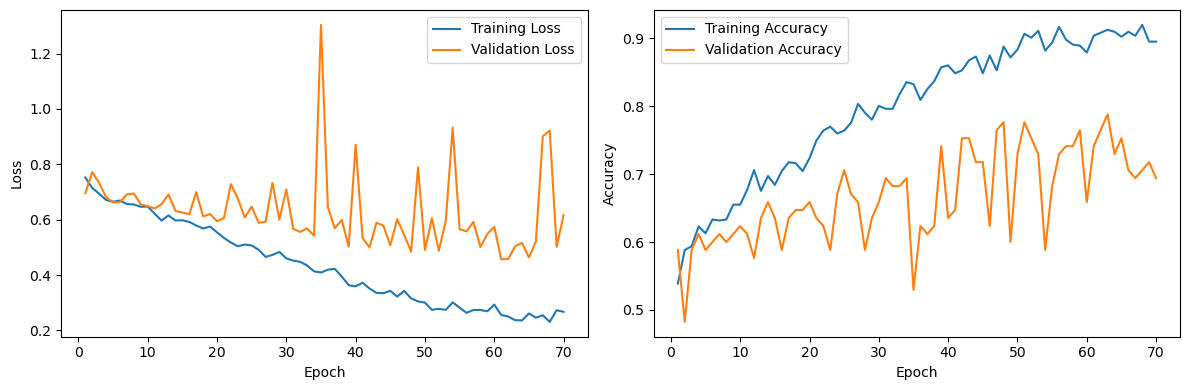

In [46]:
# Lists to store values for plotting
from cgi import test


train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Training loop
num_epochs = 70
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    for inputs, labels in tqdm(train_loader):
        # convert labels to float because criterion requires float type labels
        labels = labels.type(torch.FloatTensor)
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        predicted = outputs > 0.5
        total_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)

    average_loss = total_loss / len(train_loader)
    accuracy = total_correct / total_samples

    train_losses.append(average_loss)
    train_accuracies.append(accuracy)

    print(f'Training - Epoch {epoch+1}/{num_epochs}, Loss: {average_loss:.4f}, Accuracy: {accuracy:.4f}')

    # Validation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_samples = 0

    with torch.no_grad():
        for val_inputs, val_labels in val_loader:
            val_labels = val_labels.type(torch.FloatTensor)
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
            val_outputs = model(val_inputs)
            val_loss += criterion(val_outputs, val_labels).item()
            val_predicted = val_outputs > 0.5
            val_correct += (val_predicted == val_labels).sum().item()
            val_samples += val_labels.size(0)

    average_val_loss = val_loss / len(val_loader)
    val_accuracy = val_correct / val_samples

    val_losses.append(average_val_loss)
    val_accuracies.append(val_accuracy)

    print(f'Validation - Epoch {epoch+1}/{num_epochs}, Loss: {average_val_loss:.4f}, Accuracy: {val_accuracy:.4f}')

# Testing
model.eval()
test_correct = 0
test_samples = 0

with torch.no_grad():
    for test_inputs, test_labels in test_loader:
        test_labels = test_labels.type(torch.FloatTensor)
        test_inputs, test_labels = test_inputs.to(device), test_labels.to(device)
        test_outputs = model(test_inputs)
        test_predicted = test_outputs > 0.5
        test_correct += (test_predicted == test_labels).sum().item()
        test_samples += test_labels.size(0)

test_accuracy = test_correct / test_samples
print(f'Testing - Accuracy: {test_accuracy:.4f}')

# Plot learning curves
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


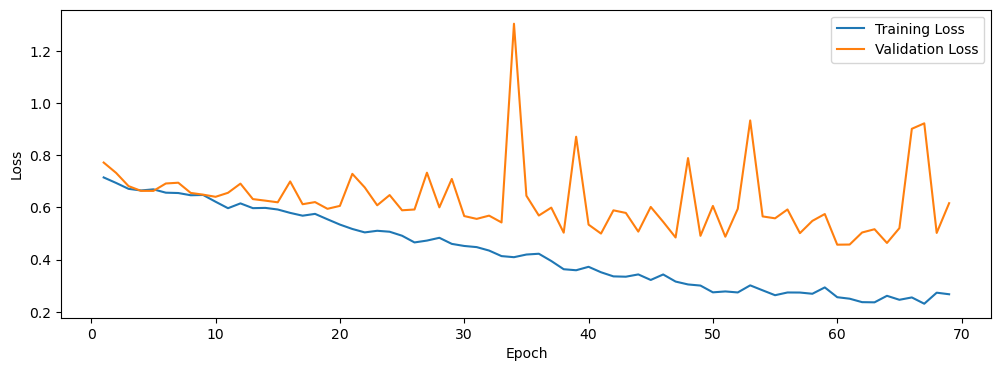

In [47]:
xrange = range(1, num_epochs)
plt.figure(figsize=(12, 4))
plt.plot(xrange, train_losses[1:], label='Training Loss')
plt.plot(xrange, val_losses[1:], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

Testing - Accuracy: 0.6667


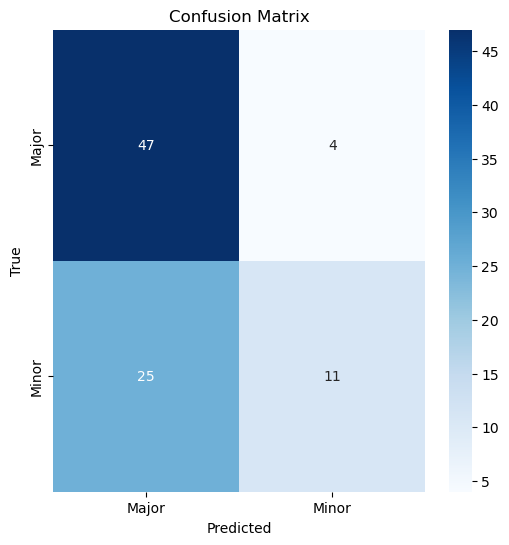

In [48]:
# Lists to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Testing
model.eval()
test_correct = 0
test_samples = 0

with torch.no_grad():
    for test_inputs, test_labels in test_loader:
        test_inputs, test_labels = test_inputs.to(device), test_labels.to(device)
        test_outputs = model(test_inputs)
        test_predicted = test_outputs > 0.5

        true_labels.extend(test_labels.cpu().numpy())
        predicted_labels.extend(test_predicted.cpu().numpy())

        test_correct += (test_predicted == test_labels).sum().item()
        test_samples += test_labels.size(0)

test_accuracy = test_correct / test_samples
print(f'Testing - Accuracy: {test_accuracy:.4f}')

# Confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
class_names = ['Major', 'Minor']  # Modify based on your actual class names

# Plot the confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()